# Playground

In [2]:
from typing import List, Set, Dict, Tuple, Optional, Any
from collections import defaultdict

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus, relu
from torch.distributions import Distribution, Normal
from torch.utils.data import DataLoader

from gmfpp.data_preparation import *
from gmfpp.data_transformers import *
from gmfpp.plotting import *


%matplotlib inline

torch.manual_seed(0)

## Load data

In [3]:
metadata = read_metadata("./data/metadata_small.csv")

In [4]:
metadata = metadata[:5] # @TODO: remove

In [5]:
relative_path = get_relative_image_paths(metadata)
image_paths = ["./data/" + path for path in relative_path]
images = load_images(image_paths)

In [6]:
len(images)

5

## VAE

In [7]:
class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        return self.mu + self.sigma * self.sample_epsilon()
        
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        return torch.distributions.Normal(loc=self.mu, scale=self.sigma).log_prob(z)

In [8]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x

In [9]:
class CytoVariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape: torch.Size, latent_features: int):
        super(CytoVariationalAutoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)
        self.observation_shape = input_shape
        self.input_channels = input_shape[0]
        
        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoder = nn.Sequential(
            # now we are at 68h * 68w * 3ch
            nn.Conv2d(in_channels=self.input_channels, out_channels=32, kernel_size=5, padding=0),
            # Now we are at: 64h * 64w * 32ch
            nn.MaxPool2d(2),
            nn.LeakyReLU(negative_slope=0.01),
            #nn.BatchNorm2d(32),

            # Now we are at: 32h * 32w * 32ch
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=0),
            # Now we are at: 28h * 28w * 32ch
            nn.MaxPool2d(2),
            # Now we are at: 14h * 14w * 32ch
            nn.LeakyReLU(negative_slope=0.01),
            #nn.BatchNorm2d(32),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=0),
            # Now we are at: 10h * 10w * 32ch
            nn.MaxPool2d(2),
            # Now we are at: 5h * 5w * 32ch
            nn.LeakyReLU(negative_slope=0.01),
            #nn.BatchNorm2d(32),

            ##Output should be 5*5*32 now.
            nn.Conv2d(in_channels=32, out_channels=2*256, kernel_size=5, padding=0),
            # Now we are at: 1h * 1w * 512ch
            #nn.BatchNorm2d(2*256),
            nn.Flatten(),
        )

        
        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256,1,1)), # Now we are at: 1h * 1w * 256ch
            nn.Conv2d(in_channels=256, out_channels=32, kernel_size=5, padding=4),
            #nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.01),
            torch.nn.UpsamplingBilinear2d(size=10),

            # Now we are at: 10h * 10w * 32ch
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=4),
            #nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.01),
            torch.nn.UpsamplingBilinear2d(size=28),

            # Now we are at: 28h * 28w * 32ch
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=4),
            #nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.01),
            torch.nn.UpsamplingBilinear2d(size=64),

            # Now we are at: 64h * 64w * 32ch
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=4),
            #nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.01),
            
            # Now we are at: 68h * 68w * 32ch
            nn.Conv2d(in_channels=32, out_channels=6, kernel_size=1, padding=0), # 6 channels because 3 for mean and 3 for variance
            #nn.BatchNorm2d(6),
            nn.LeakyReLU(negative_slope=0.01)
        )
        
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.encoder(x)
        
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        h_z = self.decoder(z)

        mu, log_sigma = h_z.chunk(2, dim=1)
        mu = mu.view(-1, *self.input_shape) # reshape the output
        log_sigma = log_sigma.view(-1, *self.input_shape) # reshape the output
        
        return Normal(loc=mu, scale=torch.exp(log_sigma), validate_args=False)

    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()

        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""
        
        # degine the prior p(z)
        pz = self.prior(batch_size=batch_size)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'z': z}


image_shape = np.array([3, 68, 68])
latent_features = 256
vae = CytoVariationalAutoencoder(image_shape, latent_features)
print(vae)

CytoVariationalAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(32, 512, kernel_size=(5, 5), stride=(1, 1))
    (10): Flatten(start_dim=1, end_dim=-1)
  )
  (decoder): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(256, 1, 1))
    (1): Conv2d(256, 32, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4))
    (2): LeakyReLU(negative_slope=0.01)
    (3): UpsamplingBilinear2d(size=10, mode=bilinear)
    (4): Conv2d(32, 32, kernel_size=(5, 5

In [10]:
class VariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape: torch.Size, latent_features: int) -> None:
        super(VariationalAutoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features=self.observation_features, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            # A Gaussian is fully characterised by its mean \mu and variance \sigma**2
            nn.Linear(in_features=128, out_features=2*latent_features)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=2*self.observation_features)
        )
        
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.encoder(x)
        mu, log_sigma = h_x.chunk(2, dim=-1)
        
        # return a distribution `q(z|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        h_z = self.decoder(z)
        mu, log_sigma = h_z.chunk(2, dim=-1)
        
        mu = mu.view(-1, *self.input_shape) # reshape the output
        log_sigma = log_sigma.view(-1, *self.input_shape) # reshape the output
        
        return Normal(loc=mu, scale=torch.exp(log_sigma), validate_args=False)

    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # flatten the input
        #x = x.view(x.size(0), -1)
        x = x.reshape(x.size(0), -1)
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""
        
        # degine the prior p(z)
        pz = self.prior(batch_size=batch_size)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'z': z}


image_shape = np.array([3, 68, 68])
latent_features = 256
vae = VariationalAutoencoder(image_shape, latent_features) 
print(vae)

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=13872, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=512, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=27744, bias=True)
  )
)


In [13]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    flat = view_flat_samples(x)
    return flat.sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta
        
    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:
        # forward pass through the model
        outputs = model(x)

        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        
        # evaluate log probabilities
        log_px = reduce(px.log_prob(x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))
        
        # compute the ELBO with and without the beta parameter: 
        # `L^\beta = E_q [ log p(x|z) ] - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        kl = log_qz - log_pz
        elbo = log_px - kl
        beta_elbo = log_px - self.beta*kl
        
        # loss
        loss = -beta_elbo.mean()
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
            
        return loss, diagnostics, outputs
      

In [14]:
train_set = prepare_raw_images(images)
normalize_channels_inplace(train_set)
print(train_set.shape)

torch.Size([5, 3, 68, 68])


In [15]:
channel_first = view_channel_dim_first(train_set)
for i in range(channel_first.shape[0]):
    channel = channel_first[i]
    print("channel {} interval: [{:.2f}; {:.2f}]".format(i, torch.min(channel), torch.max(channel)))

channel 0 interval: [0.04; 1.00]
channel 1 interval: [0.02; 1.00]
channel 2 interval: [0.03; 1.00]


In [16]:
# VAE
image_shape = np.array([3, 68, 68])
latent_features = 256
vae = CytoVariationalAutoencoder(image_shape, latent_features)
#vae = VariationalAutoencoder(image_shape, latent_features)

beta = 1
vi = VariationalInference(beta=beta)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3, weight_decay=10e-4)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

In [17]:
num_epochs = 10000
batch_size = 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

# move the model to the device
vae = vae.to(device)

# training..

for epoch in range(num_epochs):
    print(f"epoch: {epoch}/{num_epochs}")    

    training_epoch_data = defaultdict(list)
    vae.train()

    for x in train_loader:
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(vae.parameters(), 2)
        optimizer.step()

        # gather data for the current batch
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]

    print("training | elbo: {:2f}, log_px: {:.2f}, kl: {:.2f}:".format(np.mean(training_epoch_data["elbo"]), np.mean(training_epoch_data["log_px"]), np.mean(training_epoch_data["kl"])))

    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    # Evaluate on a single batch, do not propagate gradients
    with torch.no_grad():
        vae.eval()

        # Just load a single batch from the test loader
        '''x, y = next(iter(test_loader))'''
        x = x.to(device)

        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)

        # gather data for the validation step
        for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]

    print("validation | elbo: {:2f}, log_px: {:.2f}, kl: {:.2f}:".format(np.mean(validation_data["elbo"]), np.mean(validation_data["log_px"]), np.mean(validation_data["kl"])))


>> Using device: cpu
epoch: 0/10000
training | elbo: -13279.892090, log_px: -13278.69, kl: 1.20:
validation | elbo: -13279.474609, log_px: -13278.95, kl: 0.52:
epoch: 1/10000
training | elbo: -13185.223633, log_px: -13184.68, kl: 0.54:
validation | elbo: -13145.213867, log_px: -13144.54, kl: 0.68:
epoch: 2/10000
training | elbo: -13085.168945, log_px: -13085.42, kl: -0.25:
validation | elbo: -13101.236979, log_px: -13100.75, kl: 0.48:
epoch: 3/10000
training | elbo: -13037.929688, log_px: -13037.88, kl: 0.05:
validation | elbo: -13082.279785, log_px: -13081.77, kl: 0.51:
epoch: 4/10000
training | elbo: -13040.458008, log_px: -13039.45, kl: 1.01:
validation | elbo: -13081.960938, log_px: -13081.22, kl: 0.74:
epoch: 5/10000
training | elbo: -13005.788574, log_px: -13005.20, kl: 0.59:
validation | elbo: -13056.491048, log_px: -13055.85, kl: 0.65:
epoch: 6/10000
training | elbo: -12949.791992, log_px: -12949.30, kl: 0.49:
validation | elbo: -13032.842215, log_px: -13032.23, kl: 0.61:
epoch

KeyboardInterrupt: 

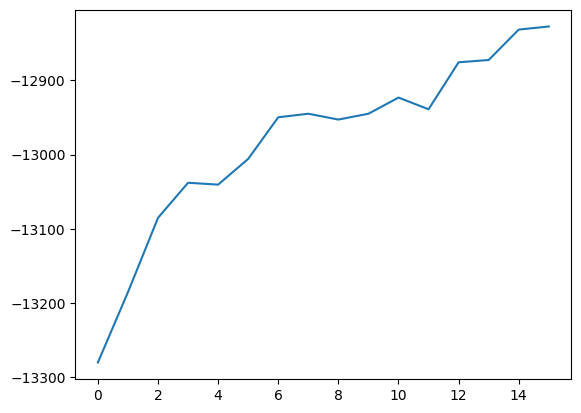

In [18]:
plt.plot(training_data["elbo"])

## Compare reconstruction and original image

In [20]:
x = train_set[0]

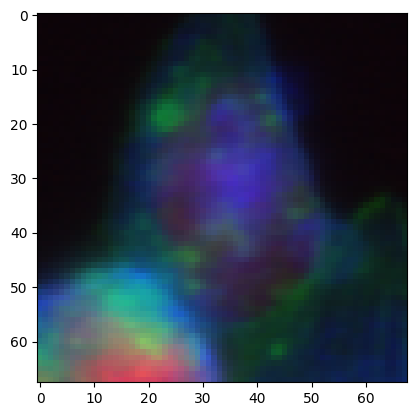

In [21]:
plot_image(x)

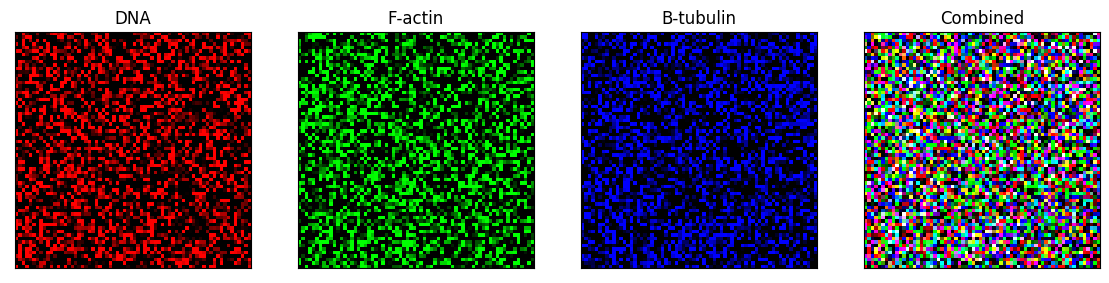

In [22]:
# vae.eval() # because of batch normalization
outputs = vae(x[None,:,:,:])
px = outputs["px"]

x_reconstruction = px.sample()
x_reconstruction = x_reconstruction[0]
plot_image_channels(x_reconstruction)

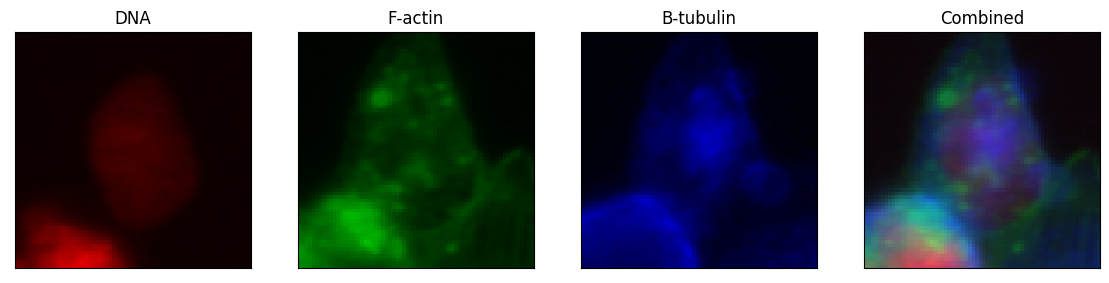

In [23]:
plot_image_channels(x)

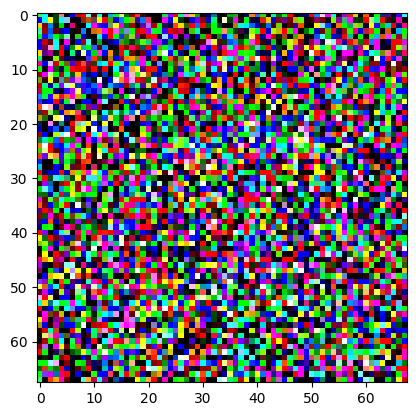

In [24]:
x_reconstruction = px.sample()
x_reconstruction = x_reconstruction[0]
plt.imshow(view_as_image_plot_format(clip_image_to_zero_one(x_reconstruction)))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2d704ace-07ad-46d7-b65e-50921c60f0ae' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>